In [106]:
import numpy as np
from sklearn.cluster import KMeans
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
class cluster_student:
    def __init__(self,dataset,cluster_number1,cluster_number2):
        self.dataset=dataset
        self.cluster_number1=cluster_number1
        self.cluster_number2=cluster_number2
    def mapping(self,x):
        if x=='ExecFinished':
            return "1"
        else:
            return "0"
    def is_outlier(self,s):
        lower_limit = s.mean() - (s.std() * 3)
        upper_limit = s.mean() + (s.std() * 3)
        return ~s.between(lower_limit, upper_limit)
    def preprocess(self):
        with open(self.dataset, encoding="utf8") as file:    
            data = json.load(file)
        new_data=[]
        for i in data.keys():
            temp=data[i]
            for exercise in temp:
                if "duration" in exercise.keys():
                    new_data.append(list(exercise.values()))
        final_data=[]
        for i in range(len(new_data)):
            if len(new_data[i])==18:
                final_data.append(new_data[i])
        
        final_data=np.array(final_data).reshape(-1,18)
        final_data=pd.DataFrame(final_data)
        final_data.columns=['_id', 'courseId', 'lessonId', 'exerciseId', 'uid', 'kernel', 'updated', 'error', 'code', 'codeType', 'status', 'updated_time', 'unit', 'env', 'submitType', 'exeTime', 'duration', '_ip']
        #做題數小於30的學生不納入評量
        a=final_data.groupby("uid")["exerciseId"].count()
        a=a[a<30]
        final_data= final_data[~final_data['uid'].isin(a.index)]
        final_data.index=range(len(final_data))
      
        final_data["correct_rate"]=final_data["status"].apply(self.mapping)
        final_data["correct_rate"]=final_data["correct_rate"].apply(lambda x:int(x))
        
        final_data["duration"].replace('None', np.nan, inplace=True)
        inplace=final_data['duration'].mean()
        final_data["duration"]=final_data["duration"].apply(lambda x:inplace if x==np.nan else x)
        
        final = final_data[~final_data.groupby('exerciseId')['duration'].apply(self.is_outlier)]
        return (final,final_data)
    def predict_exercise_difficulty(self):
        final=self.preprocess()[0]
        final_data=self.preprocess()[1]
        a1=final_data.pivot_table(index="exerciseId",columns="uid",aggfunc='count')
        med_of_upload=a1.median(axis=1)
        g=final.groupby('exerciseId')
        result=g.agg({'correct_rate':"mean", "duration":"mean"})
        result["upload_count"]=med_of_upload
        kmeans = KMeans(n_clusters=self.cluster_number1, random_state=1)
        kmeans.fit(result)
        cluster_labels = kmeans.labels_
        result = result.assign(Cluster = cluster_labels)
        temp=result.groupby(['Cluster']).agg({'correct_rate': 'mean'}).sort_values(["correct_rate"])
        temp["group"]=range(temp.shape[0],0,-1)
        di=temp.reset_index()[["Cluster","group"]].to_dict()["group"]
        result["Cluster"].replace(di, inplace=True)
        difficulty={}
        for i in range(len(result)):
            difficulty[result.index[i]]=result["Cluster"][i]
        temp=[]
        for i in range(len(final_data)):
            if final_data["status"][i]=="ExecFinished":
                temp.append(difficulty[final_data["exerciseId"][i]])
            else:
                temp.append(0)
        #temp
        final_data["answer"]=temp
        return (final_data,result.groupby(['Cluster']).agg({'correct_rate': 'mean','duration': 'median',"upload_count":"mean"}))
    def predict_student_group(self):
        final_data=self.predict_exercise_difficulty()[0]
        final_result=final_data.groupby(['uid']).agg({'answer': 'mean'})
        kmeans = KMeans(n_clusters=self.cluster_number2, random_state=1)
        kmeans.fit(final_result)
        cluster_labels = kmeans.labels_
        result = final_result.assign(Cluster = cluster_labels)
        temp=pd.DataFrame(result.groupby("Cluster")["answer"].mean().sort_values())
        temp["group"]=['Worst','Third','Second','Best']
        temp=temp.reset_index()
        di=temp.set_index("Cluster")["group"].to_dict()
        result["Cluster"].replace(di, inplace=True)
        return (result,final_data)
    def application(self):
        final_data=self.predict_student_group()[1]
        result=self.predict_student_group()[0]
        print("資料中總共有幾道題目: ",len(pd.unique(final_data["exerciseId"])))
        print("資料中總共有幾位學生: ",len(pd.unique(final_data["uid"])))
        print("\n")
        print("不同群間的學生程度差異(單位:平均加權正確率)")
        print(result.groupby(['Cluster']).agg({'answer': 'mean'}).sort_values(by="answer"))
        print("\n")
        x1=list(result[result["Cluster"]=='Third']["answer"])
        x2=list(result[result["Cluster"]=='Second']["answer"])
        x3=list(result[result["Cluster"]=='Worst']["answer"])
        x4=list(result[result["Cluster"]=='Best']["answer"])
        colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']
        names = ['Third','Second','Worst','Best']
        plt.hist([x1, x2, x3, x4],bins=100,color = colors,label=names)
    
        plt.legend()
        plt.xlabel('Correct Rate')
        plt.ylabel('Counts')
        plt.title('Student ability analysis')
    
        plt.savefig("Student ability analysis.png")
        result.reset_index()[["uid","Cluster"]].set_index("uid").to_csv('Student_ability_Result.csv')
        print("了解哪門課學生表現最差(用該門課學生答題正確率來計算)")
        print(final_data.groupby("lessonId")["answer"].mean().sort_values())
        print("\n") 
        

資料中總共有幾道題目:  189
資料中總共有幾位學生:  103


不同群間的學生程度差異(單位:平均加權正確率)
           answer
Cluster          
Worst    0.502577
Third    0.871389
Second   1.118014
Best     1.409946


了解哪門課學生表現最差(用該門課學生答題正確率來計算)
lessonId
7441f000-9588-11e9-ab4d-0d42996676ac    0.485000
2844a700-974b-11e9-b51b-97520046b077    0.657534
9e3a5e91-3680-11e9-af86-9fcbc1471ded    0.689320
60ea85e0-9267-11e9-b6ee-ad8cb1a60a53    0.690647
9e3a5e93-3680-11e9-af86-9fcbc1471ded    0.739018
9e3a5e92-3680-11e9-af86-9fcbc1471ded    0.911197
e79b5ff0-8cf0-11e9-8bcd-639e17676395    0.921875
57c1be90-8b8f-11e9-b5d6-efb5794964a5    1.000000
9e3a3780-3680-11e9-af86-9fcbc1471ded    1.011599
7441a1e0-9588-11e9-ab4d-0d42996676ac    1.020804
9e3a5e90-3680-11e9-af86-9fcbc1471ded    1.039402
8b9f8720-974b-11e9-b51b-97520046b077    1.069767
9e3a1070-3680-11e9-af86-9fcbc1471ded    1.109824
Name: answer, dtype: float64




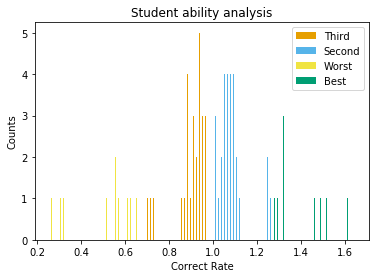

In [107]:
cluster_student('data.json',3,4).application()